In [1]:
import numpy as np
import pandas as pd
from Features import eng_func 
from Models.models import Model 

In [3]:
season21 = pd.read_csv('../../data/bbref-files/2021-22_cleaned.csv')

## Features engineering 

- Add fantasy points
- For each player: compute average statistics

In [4]:
season21['FP'] = season21.apply(eng_func.compute_fantasy_score,axis=1)

In [32]:
def fill_players_dict(df, players, col, num_games, model_type):
    """
    :param df: Season DataFrame
    :param players: list of players
    :param col: statistics taken into account in the model
    :param num_games: number of games to compute average statistics
    :param model_type: type of model
    :return: dictionary of players with models and samples
    """
    from tqdm import tqdm
    
    # Init players dictionary
    players_dict = {}
    
    # Loop over players
    pbar = tqdm(players)#, desc = 'Computing average and building model..')
    for player in pbar:
        # Extract player data and get averages statistics
        pbar.set_description(f'Computing average and building model: {player}')
        player_df = df[df['Player'] == player].sort_values(by='Date',ascending=False).copy()
        #print("Shape",player_df.shape[0])
        if player_df.shape[0]>num_games+1:
            player_df = eng_func.get_averages(player_df,num_games,col)
            player_df = player_df.dropna()
        
            # Features and output
            x_col = [f'{num_games}_{i}' for i in col] 
            X = player_df[[i for i in x_col]]
            y = player_df[['FP']]
            
            # Init class
            player_model = Model(X, y)

            # Divide data
            player_model.create_train_test_split(test_size=0.3)

            # Construct and train model
            player_model.build_model(model_type)
            player_model.train_model()

            # Evaluate
            metrics = player_model.evaluate_model()
        
            players_dict[player] = {"model":player_model,
                                    "points":{"x_train":player_model.x_train,"x_test":player_model.x_test,
                                          "y_train":player_model.y_train,"y_test":player_model.y_test,
                                          "y_pred":player_model.y_pred},
                                    "metrics":metrics
                                    }

    return players_dict

### Linear regression test

with 
- col = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
           'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
- num_games = 2 

In [33]:
col = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
           'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
num_games = 2
model = "linear_regression"
players_list = season21.Player.unique()

In [34]:
linear_dict_v1 = fill_players_dict(season21,players_list,col,num_games,model)

Computing average and building model: Sekou Doumbouya:   8%|▊         | 47/614 [00:02<00:31, 17.93it/s]       /Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Computing average and building model: E'Twaun Moore:  40%|████      | 246/614 [00:12<00:30, 12.23it/s]           /Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Computing average and building model: DeJon Jarreau:  68%|██████▊   | 417/614 [00:19<00:07, 24.64it/s]          /Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined 

In [62]:
def plot_predicted_vs_actual(models_results, model_str, player_name=None, threshold=5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from itertools import chain
    """
    Plot Predicted vs Actual values using Seaborn with color-coding for good/bad predictions.
    
    Args:
    - models_results (dict): Dictionary where keys are player names and values are dicts with 'actual' and 'predicted'.
    - player_name (str): Specific player name to plot. If None, plots all players on the same graph.
    - threshold (int): Threshold for a good prediction (default is 5).
    """
    plt.figure(figsize=(10, 6))
    if player_name:
        actual = np.array(models_results[player_name]['points']['y_test'])
        predicted = np.array(models_results[player_name]['points']['y_pred'])
    else:
        actual = list(chain.from_iterable(data["points"]["y_test"].values for data in models_results.values()))
        predicted = list(chain.from_iterable(data["points"]["y_pred"] for data in models_results.values()))
        
        actual = np.array(actual)
        predicted = np.array(predicted)

    actual = actual.ravel()
    predicted = predicted.ravel()
        
    # Define colors based on the threshold
    colors = ['green' if abs(a - p) <= threshold else 'red' for a, p in zip(actual, predicted)]
        
    # Create a DataFrame for Seaborn
    df = pd.DataFrame({
            'Actual': actual,
            'Predicted': predicted,
            'Color': colors
    })
        
    # Scatter plot using Seaborn
    sns.scatterplot(data=df, x='Actual', y='Predicted', hue='Color', palette={'green': 'green', 'red': 'red'}, alpha=0.7)
    plt.plot(actual, actual, color='black', lw=2) 
    
    # Calculate the ratio of good predictions
    good_predictions = sum(1 for color in colors if color == 'green')
    total_predictions = len(colors)
    good_prediction_ratio = good_predictions / total_predictions * 100
    
    plt.ylim((-20,100))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual with Threshold')
    plt.title(f'{model_str} - Predicted vs Actual (Good Predictions: {good_prediction_ratio:.2f}%)')
    plt.grid()
    plt.show()

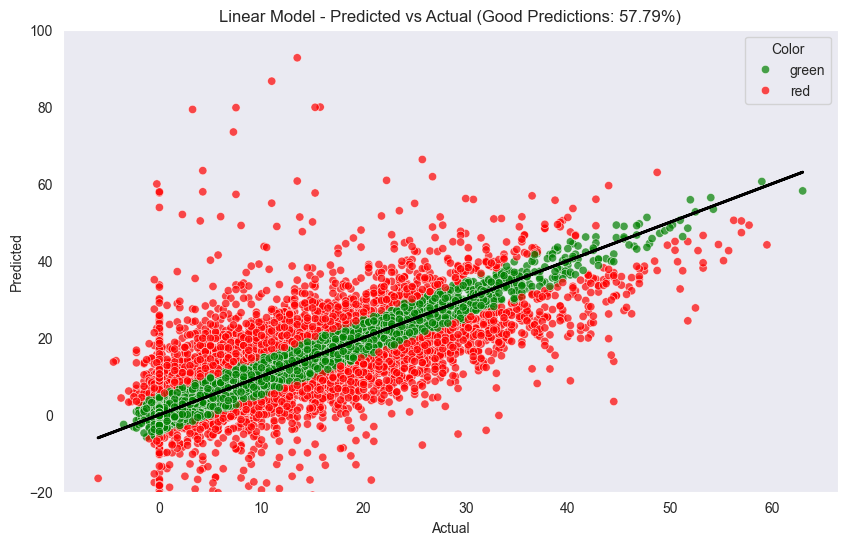

In [55]:
plot_predicted_vs_actual(linear_dict_v1,"Linear Model")

In [52]:
np.array(list(chain.from_iterable(data["points"]["y_pred"] for data in linear_dict_v1.values()))).ravel().shape

(8461,)

with 
- col = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
           'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
- num_games = 4

In [88]:
num_games = 4
model = "linear_regression"

In [89]:
linear_dict_v2 = fill_players_dict(season21,players_list,col,num_games,model)

Computing average and building model: JaQuori McLaughlin:  73%|███████▎  | 448/614 [00:21<00:05, 28.74it/s]      /Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Computing average and building model: Jay Huff:  75%|███████▍  | 460/614 [00:21<00:05, 26.05it/s]          /Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Computing average and building model: Scottie Lewis:  79%|███████▉  | 488/614 [00:22<00:04, 25.78it/s]      /Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with le

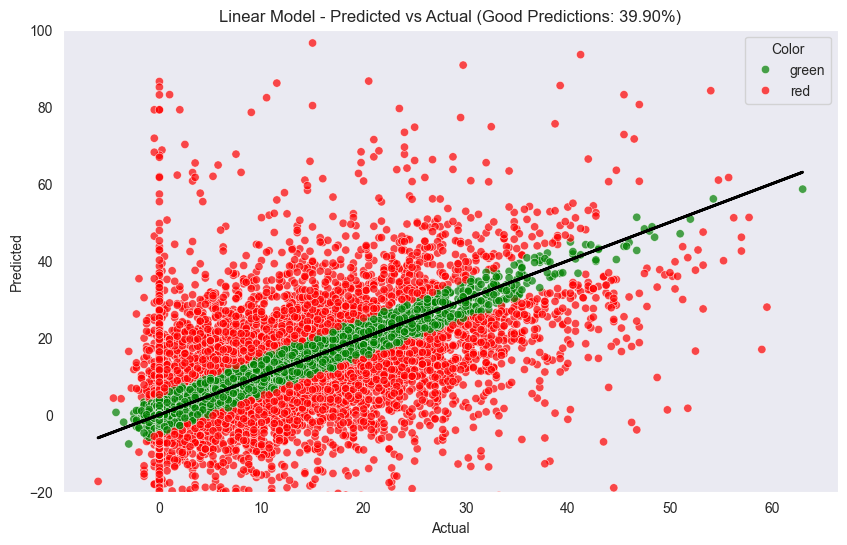

In [90]:
plot_predicted_vs_actual(linear_dict_v2)

## Random Forest test

- col = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
           'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
- num_games = 2



In [9]:
num_games = 2
model = "random_forest"

In [10]:
rf_dict_v1 = fill_players_dict(season21,players_list,col,num_games,model)

Computing average and building model: Joe Harris:   0%|          | 0/614 [00:00<?, ?it/s]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Computing average and building model: James Harden:   0%|          | 1/614 [00:01<10:47,  1.06s/it]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Computing average and building model: Kevin Durant:   0%|          | 2/614 [00:01<07:26,  1.37it/s]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/base.py:1

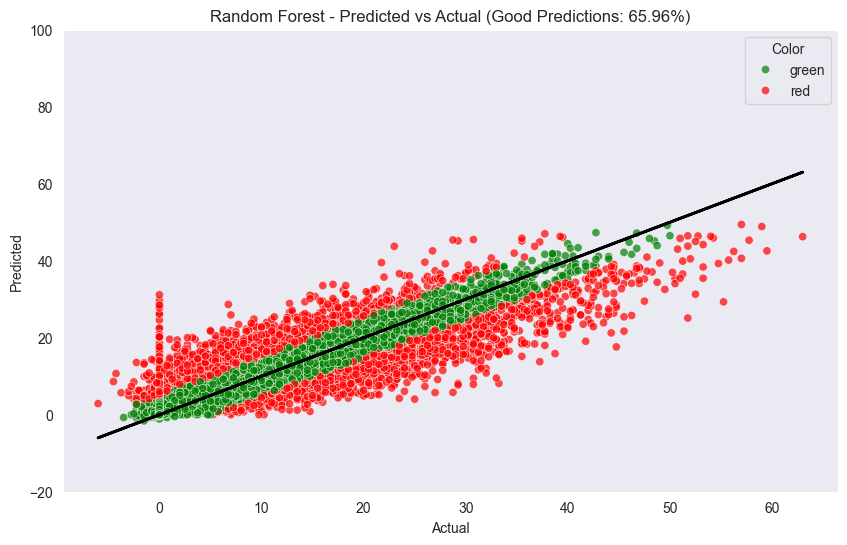

In [66]:
plot_predicted_vs_actual(rf_dict_v1,"Random Forest")

- col = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
           'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-','FP']
- num_games = 2

In [63]:
col = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
           'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-','FP']
num_games = 2
model = "random_forest"

In [64]:
rf_dict_v2 = fill_players_dict(season21,players_list,col,num_games,model)

Computing average and building model: Joe Harris:   0%|          | 0/614 [00:00<?, ?it/s]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Computing average and building model: James Harden:   0%|          | 1/614 [00:00<04:39,  2.19it/s]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Computing average and building model: Kevin Durant:   0%|          | 2/614 [00:00<05:01,  2.03it/s]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/base.py:1

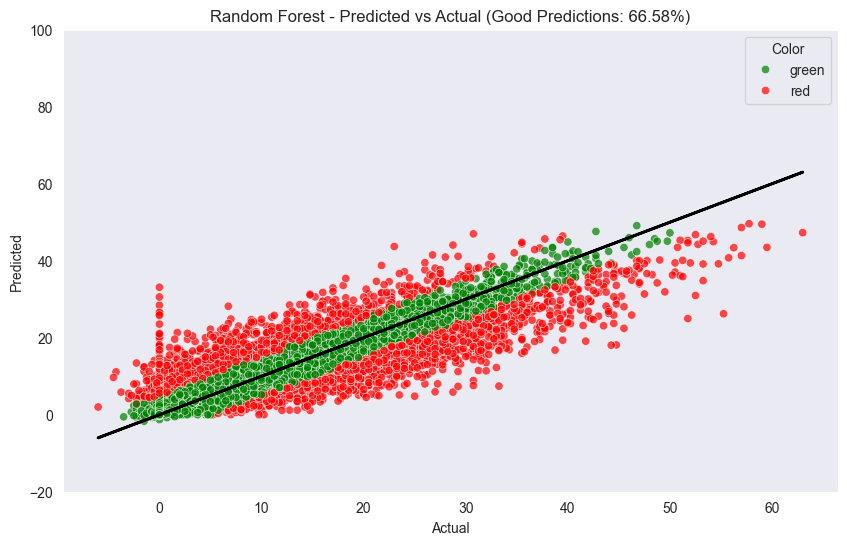

In [67]:
plot_predicted_vs_actual(rf_dict_v2,"Random Forest")

## Support Vector Machine

- col = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
           'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
- num_games = 2



In [69]:
col = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
           'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
num_games = 2
model = "svm"

In [70]:
svm_dict_v1 = fill_players_dict(season21,players_list,col,num_games,model)

Computing average and building model: Joe Harris:   0%|          | 0/614 [00:00<?, ?it/s]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Computing average and building model: James Harden:   0%|          | 1/614 [00:00<01:25,  7.19it/s]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Computing average and building model: Kevin Durant:   0%|          | 2/614 [00:00<01:18,  7.78it/s]/Users/julialegrand/PycharmProjects/FantasyNBA/.venv/lib/python3.10/site-packages/sklearn/utils/validat

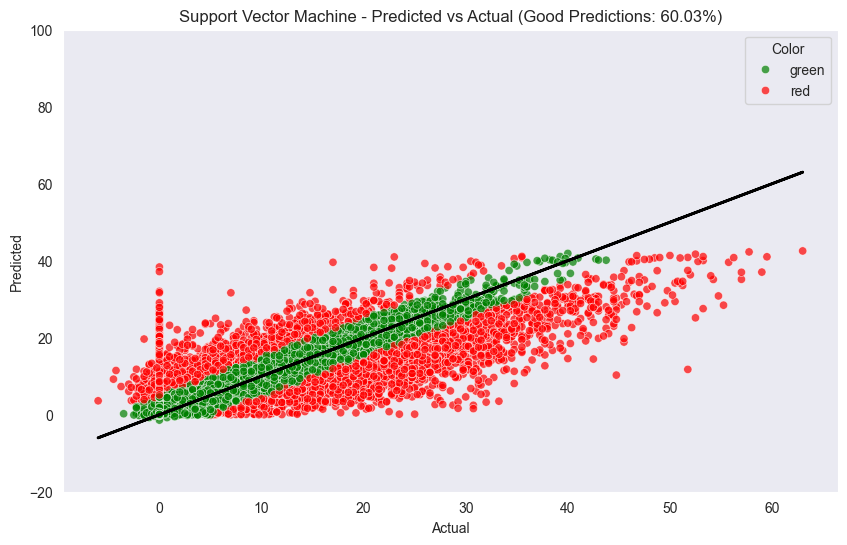

In [71]:
plot_predicted_vs_actual(svm_dict_v1,"Support Vector Machine")